### 準備

このプログラムではグラフ表示のために **graphviz** というツールを使っていますので、実行に先立って graphviz を使えるようにするための作業が必要です。その内容は、「[Windows10 で Graphviz を使うための設定](http://localhost:8888/notebooks/ML02%20%E6%B1%BA%E5%AE%9A%E6%9C%A8%E3%81%AE%E5%AD%A6%E7%BF%92/Windows10%20%E3%81%A6%E3%82%99%20Graphviz%20%E3%82%92%E4%BD%BF%E3%81%86%E3%81%9F%E3%82%81%E3%81%AE%E8%A8%AD%E5%AE%9A.ipynb)」に書いてありますので、先にそちらを済ませて下さい。


In [1]:
# !pip install graphviz  
# !pip install pydotplus 

In [1]:
# モジュールのインポート
import pandas as pd
from sklearn import tree
from sklearn.externals.six import StringIO
from graphviz import Digraph
import pydotplus
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from  PIL import Image,ImageDraw,ImageFont
import numpy as np
from IPython.display import display

FONTPATH = "C:\\Windows\\Fonts\\meiryo.ttc"  # for Windows
# FONTPATH = '/Library/Fonts/SFNSText.ttf'  # for Macintosh

![2017-09-23 18 27 59](https://user-images.githubusercontent.com/5820803/30771930-0fbc20de-a08d-11e7-922a-6e8e641170f4.PNG)

決定木作成の対象となる表を Excel で作り、データを含む部分を図のように選択してクリップボードにコピーして次のブロックを実行する。  
次のブロックのプログラムは クリップボード内のデータを取り込んで python で扱えるデータに変換するプログラムである。 
結果が df に代入され、プログラムで扱えるようになる。

In [3]:
df = pd.read_clipboard()
items1 = df.columns[1:5] # 分類に使う項目は１〜４
df

,顧客番号,住居形態,家族構成,収入,ローン残,販売実績,判定結果
0,1,0,0,0,1,×,NaN
1,2,1,2,1,1,×,NaN
2,5,1,1,0,1,×,NaN
3,6,0,0,1,1,×,NaN
4,3,0,2,1,0,○,NaN
5,4,0,1,1,0,○,NaN
6,7,0,2,0,0,×,NaN
7,8,1,2,1,0,○,NaN


# 決定木の生成プログラム

# 決定木の準備

In [4]:
classifier = tree.DecisionTreeClassifier(criterion='entropy')

# 訓練データをもとに決定木を構成する


In [5]:
classifier.fit(df[items1],df['販売実績']);

# 完成した決定木をpng画像として出力

In [6]:
dot_data = StringIO() # 仮想テキストファイル
tree.export_graphviz(classifier, out_file=dot_data) # 決定木の描画用データ dot_data を生成する
dot_text = dot_data.getvalue() # dot_data を文字列として取り出し， X[_] を表見出しに使っている言葉で置換
for i in range(len(items1)):
    dot_text = dot_text.replace('X[{}]'.format(i),items1[i])
dot_text

'digraph Tree {\nnode [shape=box] ;\n0 [label="ローン残 <= 0.5\\nentropy = 0.9544\\nsamples = 8\\nvalue = [5, 3]"] ;\n1 [label="収入 <= 0.5\\nentropy = 0.8113\\nsamples = 4\\nvalue = [1, 3]"] ;\n0 -> 1 [labeldistance=2.5, labelangle=45, headlabel="True"] ;\n2 [label="entropy = 0.0\\nsamples = 1\\nvalue = [1, 0]"] ;\n1 -> 2 ;\n3 [label="entropy = 0.0\\nsamples = 3\\nvalue = [0, 3]"] ;\n1 -> 3 ;\n4 [label="entropy = 0.0\\nsamples = 4\\nvalue = [4, 0]"] ;\n0 -> 4 [labeldistance=2.5, labelangle=-45, headlabel="False"] ;\n}'

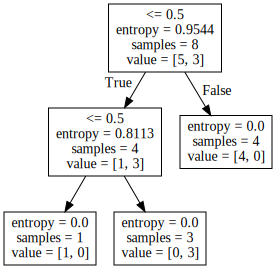

In [7]:
from graphviz import Source
src = Source(dot_text)
src.format="png"
src.render("juutaku.png")
src

### 解説
既知の８ケース中、住宅形態、家族構成、収入、ローン残高の４項目のうち一つだけで決まっている可能性を考える。  
- 「住宅形態」をチェックすると、マンション住まいの人がかならず買ってくれる、あるいは買わないということはない。一戸建ても同様である。
- 「家族構成」では、独身は買わないようである、ということだけわかる。独身は８ケース中２ケースだから、この法則が正しいなら、1/4 は独身かどうかだけチェックしたら確定する。
- 「収入」については、高収入の人は買ってくれることもあるが必ずそうとも限らない。低収入の人は総じて買わない。この経験的知識で判断できるケースは3/8である。
- 「ローン残高」の場合は、残高がある人は購入してくれたないという法則が成り立ちそうである。これで判断できるのは 1/2

よって、効率を考えれば、「ローン残高」を最初のチェック項目とするのがよいという結論になる。この項目で八件中四件は購入しないと予測できるので、あとは残りの４件に絞って次の判断項目を考えればよい。  

残り４件も同様にしてどの項目が実績のあるなしと相関があるかを調べていけばよいのだが、次は簡単で、収入の高低と実績の有無が完全に一致しているので、２つ目の検査項目は「収入」がベストであるのは自明である。

上の図では、「ローン残 <= 0.5」と表示されているが、ローン残は０か１かのデータとしているので、True はローン残が０つまり「なし」、False は「あり」を意味する。



### 補足
上の図は、次のようにしても作れる。
```
graph = pydotplus.graph_from_dot_data(dot_text)
for node in graph.get_nodes():
    node.set_fontname("Meiryo")
graph.write_png('douna.png');  #png 画像として書き出し
```

# 全判定結果

In [8]:
df['判定結果']=classifier.predict(df[items1])
df

,顧客番号,住居形態,家族構成,収入,ローン残,販売実績,判定結果
0,1,0,0,0,1,×,×
1,2,1,2,1,1,×,×
2,5,1,1,0,1,×,×
3,6,0,0,1,1,×,×
4,3,0,2,1,0,○,○
5,4,0,1,1,0,○,○
6,7,0,2,0,0,×,×
7,8,1,2,1,0,○,○


In [9]:
print("正解率 {:3.2f}　％".format((df['販売実績'] != ｄｆ['判定結果']).value_counts()[False]*100/8))

正解率 100.00　％
